In [7]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

In [2]:
domain_name="localhost"
port=3000
auth_token = json.dumps(
            {
                "email":"1000@gmail.com",
                 "password":"qwert2000"
            })

In [3]:
def query(table_name="patient",uri="",payload="",headers={},action="GET"):
    url = f"http://{domain_name}:{port}/tables/{table_name}{uri}"
#     print(url)

    response = requests.request(action, url, headers=headers, data=payload)

    return(json.loads(response.text))

## Sampling

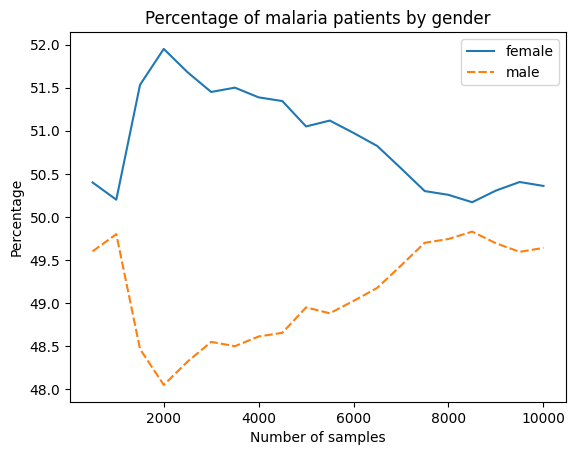

Done Querying!


In [37]:
previous_indexes = []
sample_patients_dict_df = pd.DataFrame()
gender_df = None
len_previous_indexes=[]
while(True):
    sample_patients_dict = query(table_name="patient",
          uri="/sampling",
          payload=json.dumps({
                  "batch_size": 500,
                  "previous_indexes": previous_indexes
                }),
          headers={
              'Authorization': auth_token,
              'Content-Type': 'application/json'
            },
          action="GET")
    if 'error' in sample_patients_dict.keys():
        print(sample_patients_dict)
        break
    sample_patients_dict_df = pd.DataFrame.from_dict(sample_patients_dict["data"],orient='index')
    if gender_df is None:
        gender_df = sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
        gender_df_history = 100*gender_df/gender_df.sum(axis=1)[0]
    else:
        gender_df = gender_df + sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
        gender_df_history = pd.concat([gender_df_history,100*gender_df/gender_df.sum(axis=1)[0]],axis=0,ignore_index=True)
    previous_indexes = previous_indexes+sample_patients_dict_df["id"].tolist()
    len_previous_indexes.append(len(previous_indexes))
    gender_df_history=gender_df_history.set_index([len_previous_indexes])
    display.clear_output(wait=True)
    sns.lineplot(gender_df_history)
    plt.legend()
    plt.title("Percentage of malaria patients by gender")
    plt.xlabel("Number of samples")
    plt.ylabel("Percentage")
    plt.show()

    print("Fetched entries:",len_previous_indexes[-1],"out of",
          sample_patients_dict["original_table_length"],end="\r")
    if len(previous_indexes)==sample_patients_dict["original_table_length"]:
        print("Done Querying!")
        break




In [35]:
# gender_df_history.set_index([len_previous_indexes])
# # sns.scatterplot(gender_df_history)
gender_df

gender,female,male
population,NaN,4965


In [158]:
gender_df=sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
gender_df_history = gender_df.copy()
gender_df

gender,female
population,4


In [172]:
# gender_df_history = pd.concat([gender_df_history,gender_df],axis=0)
gender_df_history.male.tail(1)

1    473
Name: male, dtype: int64

In [143]:
gender_df = sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
# gender_df["percentage"] = 100*gender_df.population/(gender_df.population.sum())
# gender_df = gender_df.transpose()
gender_df

gender,female,male
population,1478,1524


In [134]:
pd.concat([gender_df,gender_df],axis=0).reset_index(drop=True).index

RangeIndex(start=0, stop=2, step=1)

In [167]:
len_previous_indexes[-1],100*gender_df_history.male[-1]/len_previous_indexes[-1],"r"

(500, 46.4, 'r')

In [23]:
gender_df_history.set_index([len_previous_indexes]).index

Int64Index([  500,   999,  1499,  1999,  2499,  2999,  3499,  3999,  4499,
             4999,  5499,  5998,  6498,  6998,  7498,  7997,  8496,  8996,
             9496,  9995, 10002],
           dtype='int64')

In [62]:
" or id=".join([str(i) for i in []])

''

In [189]:
gender_df/gender_df.sum(axis=1)[0]

gender,female,male
population,0.503599,0.496401


In [118]:
[i for i in gender_df_history.index]

[0, 1, 2, 3]